## 블랙 숄즈 모형

<io>
    대표적인 유럽형 콜 옵션 (만기일에만 행사) 모형 중 하나인 블랙-숄즈 모형은, 주가의 수익률이 정규분포를 따르며, 기초자산에 대한 변동성은 상수로 가정한다. <br>
    또한, 시장은 효율적이며 거래비용이나 세금이 없으며 무위험이자율 역시 알려져 있다. 

In [25]:
import yfinance as yf

ks_yf = yf.Ticker('^KS11')
ks200 = ks_yf.history(period="1y") #KOSPI 200의 최근 1년 주가지수를 불러옴
ks200

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-02-06 00:00:00+09:00,2461.820068,2469.419922,2438.040039,2438.189941,566600,0.0,0.0
2023-02-07 00:00:00+09:00,2440.139893,2456.169922,2432.399902,2451.709961,446600,0.0,0.0
2023-02-08 00:00:00+09:00,2469.419922,2487.350098,2465.959961,2483.639893,414800,0.0,0.0
2023-02-09 00:00:00+09:00,2470.659912,2487.139893,2466.610107,2481.520020,609400,0.0,0.0
2023-02-10 00:00:00+09:00,2470.649902,2473.800049,2454.739990,2469.729980,656900,0.0,0.0
...,...,...,...,...,...,...,...
2024-01-30 00:00:00+09:00,2523.679932,2528.540039,2498.810059,2498.810059,481800,0.0,0.0
2024-01-31 00:00:00+09:00,2487.899902,2502.449951,2486.969971,2497.090088,437600,0.0,0.0
2024-02-01 00:00:00+09:00,2491.929932,2542.459961,2491.929932,2542.459961,751100,0.0,0.0


In [28]:
import numpy as np

ks200.index = ks200.index.date  #date형태로만 바꿔줌
ks200['Diff'] = np.log(ks200['Close']/ks200['Close'].shift(1))
ks200 = ks200.dropna()
ks200 = ks200[['Close', 'Volume', 'Diff']]


#시간 단위는 연 기준이고, 1년의 데이터를 긁었지만, len로 판단하기로 함
T = 1 #1년 선물
N = T*len(ks200)
dt = T/N #시간변화율
t = [i for i in np.arange(0, T, dt)]

#ks200['dS'] = ks200['Close']*np.sqrt(dt) 만일 실제 주가지수가 아닌 랜덤값을 사용한다면 시간에 따른 변동성을 고려하기(브라운운동) 위해서 해 줘야됨

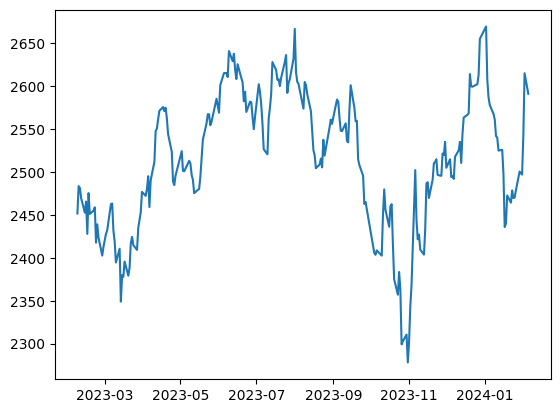

In [29]:
import matplotlib.pyplot as plt

plt.plot(ks200['Close'])

<io>
    선물가격 : $F = Se^{(r-d)T}$ <br>
    F : 선물가격, S : 기초자산 가격, r : 연간 무위험이자율, d : 연간 배당 수익률, T : 선물계약 만기까지 남은 시간(연단위)

In [32]:
F = []
r = 0.02 #무위험이자율 2% 가정
d = 0.015 #배당 수익률 1.5% 가정

for index, S0 in enumerate(ks200['Close']):
    tt = N - (index + 1)
    FF = S0*np.exp((r-d)*tt) #T가 만기까지 남은 시간, 즉 기존 시간인 N = len(df['Close']) 에서, 지금까지 흐른 일인 index+1을 빼준 것을 tt로 함
    F.append(FF)
ks200['F'] = F #선물가격 F를 대입

### 블랙숄즈 방정식

<io>
    1. 콜 옵션 <br>
    $C = S_0N(d_1) - Ke^{-rt}N(d_2)$ <br>
    -$S_0$는 기초자산 현재 가격, K는 옵션의 행사 가격 (유럽형 옵션이므로, "at-the-money"를 가정하여 기초자산의 가격으로 함 <br>
    -r은 무위험 이자율, t는 만기까지 남은 시간, N은 cumulative normal distribution <br>
    $d_1 = \frac{ln(\frac{S_0}{K})+(r+\frac{\sigma^2}{2})t}{\sigma\sqrt(t)}$ <br>
    $d_2 = d_1 - \sigma\sqrt(t) $ <br>
    $\sigma$ 는 기초자산의 연간 변동성 (현재는 지금 가진 1년치 데이터의 표준편차로 고정할 예정) <br>
    <br>
    2. 풋 옵션
    $P = Ke^{-rt}N(-d_2) - S_0N(-d_1)$

In [38]:
import scipy.stats as stat #표준정규분포 사용하려고

Call = []
Put = []

r = 0.02 #무위험이자율 2% 가정
d = 0.015 #배당 수익률 1.5% 가정
sigma = np.sqrt(N)*ks200['Diff'].std() #현재 데이터의 일별 수익률의 표준편차를 연간 변동성화 함
K = ks200['Close'][0] #기초자산 처음의 가격
for index, S0 in enumerate(ks200['Close']):
    tt = N - (index+1)
    d1 = (np.log(S0/K) + (r + ((sigma)**2)/2)*tt) / (sigma * np.sqrt(tt))
    d2 = d1 - sigma * np.sqrt(tt)

    #Call option 계산
    CC = S0*stat.norm.cdf(d1) - K*np.exp(-r*tt)*stat.norm.cdf(d2)
    Call.append(CC)

    #Put option 계산
    PP = K*np.exp(-r*tt)*stat.norm.cdf(d2) - S0*stat.norm.cdf(-d1)
    Put.append(PP)
ks200['Call'] = Call
ks200['Put'] = Put
    

/tmp/ipykernel_4829/2256161299.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S0/K) + (r + ((sigma)**2)/2)*tt) / (sigma * np.sqrt(tt))


In [43]:
ks200

,Close,Volume,Diff,F,Call,Put
2023-02-07,2451.709961,446600,0.005530,8346.027894,2435.609499,13.213892
2023-02-08,2483.639893,414800,0.012939,8412.554579,2467.199332,13.503966
2023-02-09,2481.520020,609400,-0.000854,8363.452192,2464.752859,13.760279
2023-02-10,2469.729980,656900,-0.004762,8282.201585,2452.635772,14.009672
2023-02-13,2452.699951,485500,-0.006919,8184.068828,2435.275811,14.256717
...,...,...,...,...,...,...
2024-01-30,2498.810059,481800,-0.000736,2549.289370,421.970729,493.810534
2024-01-31,2497.090088,437600,-0.000689,2534.828772,358.072283,469.842184
2024-02-01,2542.459961,751100,0.018006,2568.012108,317.182951,586.387535
2024-02-02,2615.310059,588700,0.028251,2628.419355,281.707537,950.695427


<Axes: >

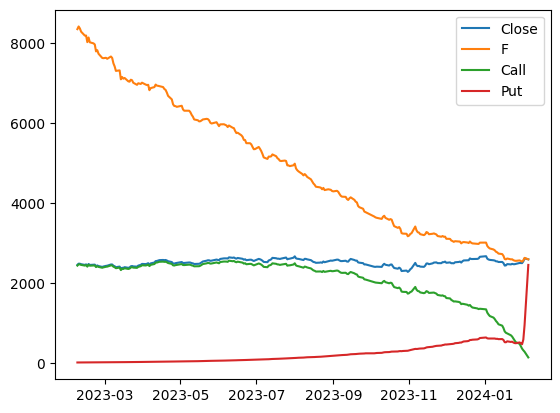

In [45]:
ks200[['Close', 'F', 'Call', 'Put']].plot()